In [1]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from sklearn.neighbors import KernelDensity  # kernel density estimation
from mpmath import jtheta  # jacobi elliptic theta function

Import list of all minor planet discoveries from MPC and list of all minor planets from the MPC `MPCORB` `.json` file, using the same data set as Granvik 2016, 2017, 2018:

Note that the `.json` files need to be gotten from the MPC for local use

In [2]:
# list of minor planet discoveries from the MPC
discovery_data = pd.read_json('numberedmps.json').T
# list of all minor planets from the MPC:
all_mps = pd.read_json('mpcorb_extended.json')

# all_neos = pd.read_csv('all_17_25_neos.csv')

Filtering list of minor planet discoveries to only consider discoveries made by CSS between $2005$ and $2012$:

In [3]:
# Discoverers are 'CSS' or 'Catalina Sky Survey' and discovery date is between January 1, 2005 and December 31, 2012
css_discoveries = discovery_data[((discovery_data.Discoverers == 'CSS') | (discovery_data.Discoverers == 'Catalina Sky Survey')) 
& ('2005-01-01' < discovery_data.Discovery_date) & (discovery_data.Discovery_date < '2012-12-31')]
# reset index since it's actually the minor planet number
css_discoveries['mp_number'] = css_discoveries.index.astype(str)
css_discoveries.reset_index(drop=True, inplace=True)
# convert Name from nan to empty string
css_discoveries = css_discoveries.fillna('')
# make full name column by combining the number, name (if it has one) and principal designation
css_discoveries['full_name'] = css_discoveries.mp_number + css_discoveries.Name + ' (' + css_discoveries.Principal_desig + ')'
css_discoveries['mp_number'] = '(' + css_discoveries.mp_number + ')'

/tmp/ipykernel_40900/1264834492.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  css_discoveries['mp_number'] = css_discoveries.index.astype(str)


In [4]:
np.min(css_discoveries.Discovery_date), np.max(css_discoveries.Discovery_date)

('2005-01-06', '2012-12-21')

In [5]:
css_discoveries

,Name,Discovery_date,Discovery_rule,Discovery_site,Discoverers,Principal_desig,Ref,mp_number,full_name
0,,2005-01-06,old,Catalina,CSS,2005 AS2,,(99943),99943 (2005 AS2)
1,,2005-01-06,old,Catalina,CSS,2005 AO7,,(117399),117399 (2005 AO7)
2,,2005-01-06,old,Catalina,CSS,2005 AA8,,(117400),117400 (2005 AA8)
3,,2005-01-06,old,Catalina,CSS,2005 AL8,,(117401),117401 (2005 AL8)
4,,2005-01-06,old,Catalina,CSS,2005 AM8,,(117402),117402 (2005 AM8)
...,...,...,...,...,...,...,...,...,...
25950,,2006-05-04,new,Catalina,CSS,2019 EV1,,(659447),659447 (2019 EV1)
25951,,2006-02-24,new,Catalina,CSS,2019 FH3,,(659451),659451 (2019 FH3)
25952,,2008-03-11,new,Catalina,CSS,2019 FM7,,(659458),659458 (2019 FM7)
25953,,2010-10-09,new,Catalina,CSS,2019 SV65,,(659619),659619 (2019 SV65)


Now filter list of minor planets to only include the ones discovered by CSS and be NEOs ($q < 1.3$ AU):

In [6]:
all_mps['q'] = (all_mps.a * (1. - all_mps.e))
# filter for NEOs
all_neos = all_mps[all_mps.q < 1.3]
# filter for CSS neos
css_neos = all_neos[all_neos.Number.isin(css_discoveries.mp_number)]

Now filter list of NEOs to only include ones with $17 < H < 25$ and get their $q$s:

In [7]:
# filter for 17 < H < 25:
mag_limited_neos = css_neos[(17. < css_neos.H) & (css_neos.H < 25.)]
mag_limited_qs = mag_limited_neos.q

In [8]:
mag_limited_neos

,Critical_list_numbered_object_flag,H,G,Num_obs,rms,U,Arc_years,Perturbers,Perturbers_2,Number,...,Aphelion_dist,Semilatus_rectum,Synodic_period,Orbit_type,NEO_flag,One_km_NEO_flag,PHA_flag,One_opposition_object_flag,Arc_length,q
155109,NaN,17.49,0.15,866.0,0.63,0,1998-2022,M-v,3El,(155110),...,1.701011,0.554138,3.399326,Apollo,1.0,1.0,NaN,NaN,NaN,0.821883
155139,NaN,17.47,0.15,902.0,0.52,0,1982-2024,M-v,3Ek,(155140),...,2.386879,0.152041,3.277624,Apollo,1.0,1.0,NaN,NaN,NaN,0.162385
155337,NaN,20.40,0.15,126.0,0.69,1,2002-2007,M-v,3Ek,(155338),...,2.326453,0.601886,2.035515,Apollo,1.0,NaN,1.0,NaN,NaN,0.811949
172973,NaN,19.42,0.15,194.0,0.70,0,2002-2019,M-v,3Ek,(172974),...,2.040517,0.768668,1.913892,Amor,1.0,NaN,NaN,NaN,NaN,1.233228
212545,NaN,17.72,0.15,360.0,0.76,0,2003-2024,M-v,3Ek,(212546),...,3.231145,0.783130,1.473061,Amor,1.0,1.0,1.0,NaN,NaN,1.033657
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
620069,NaN,18.62,0.15,569.0,0.72,0,2004-2018,M-v,3Ek,(620070),...,3.546653,0.801738,1.405136,Amor,1.0,NaN,NaN,NaN,NaN,1.035911
620070,NaN,19.64,0.15,325.0,0.60,0,2011-2020,M-v,3Ek,(620071),...,2.260772,0.160631,3.921331,Apollo,1.0,NaN,1.0,NaN,NaN,0.172917
625787,NaN,19.35,0.15,115.0,0.69,0,2006-2020,M-v,3Ek,(625788),...,4.505407,0.841059,1.277040,Amor,1.0,NaN,NaN,NaN,NaN,1.034103
625990,NaN,21.41,0.15,108.0,0.83,0,2006-2023,M-v,3Ek,(625991),...,1.267671,0.315688,3.452523,Aten,1.0,NaN,NaN,NaN,NaN,0.420373


259 NEOs when using both the MPCORB.json file and when querying NASA's SBDB... seems to be less than what Granvik et al. 2016 and 2018 suggest though

Importing the Monte Carlo cloned impactors and computing their $q$ (perihelion distance) values from $a$ and $e$:

$q = a\left(1 - e\right)$

In [9]:
orb_param_array_all_events = np.load('orb_params_all_events_mc.npy')  # get the orbital parameters for the clones
orb_param_array_true = np.load('true_impactor_aeis.npy')  # and for the true 14 impactors
orb_param_variables = ['a', 'e', 'i', 'peri', 'node', 'M']  

# get orbital param variables from the numpy files
impactor_as, impactor_es, impactor_is, impactor_peris, impactor_nodes, impactor_Ms = orb_param_array_all_events.T
true_as, true_es, true_is, true_peris, true_nodes, true_Ms = orb_param_array_true.T

# compute q from q = a * (1. - e)
impactor_qs = (impactor_as * (1. - impactor_es))
impactor_qs_flat = impactor_qs.reshape(-1)

Plotting un-weighted normalized histograms for the $q$ values of the cloned impactors and the CSS NEOs:

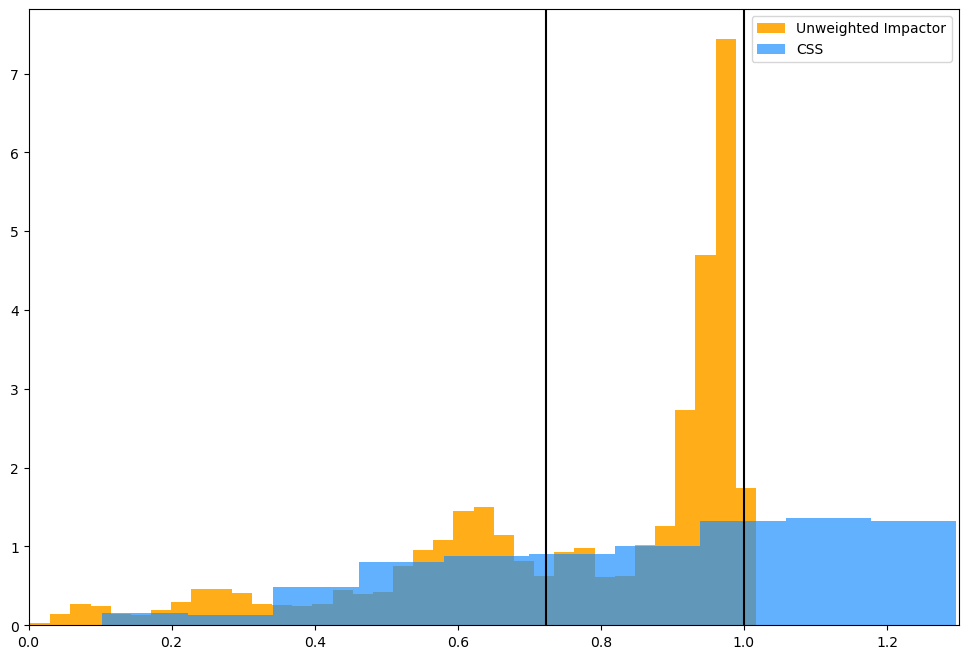

In [10]:
# semi major axes of earth and venus
a_earth = 1.
a_venus = 0.72333199

plt.figure(figsize = (12, 8))
plt.hist(impactor_qs_flat, bins='auto', color = 'orange', label = 'Unweighted Impactor', density=True, alpha=0.9)
plt.hist(mag_limited_qs, bins='auto', color='dodgerblue', label = 'CSS', density=True, alpha=0.7)
# plt.yscale('log')
plt.axvline(a_earth, color = 'k')
plt.axvline(a_venus, color = 'k')
plt.xlim(left=0., right=1.3)
plt.legend()

Compare using a K-S test and find the $p$-value:

In [11]:
import scipy.stats
scipy.stats.ks_2samp(impactor_qs_flat, mag_limited_qs).pvalue

3.940264020924297e-34

Now compute weights for each of the impactors from their Opik impact probability, given $a$, $e$ and $i$:

Use the same function for collision probability per revolution in the `monte_carlo_granvik_model.ipynb` notebook:

In [12]:
# constants for earth and sun
a0 = 1.  # semi-major axis of earth in au
m = 5.97e24  # mass of earth in kg
R = 4.259e-5  # radius of earth in au
M = 1.988e30  # mass of sun in kg

# get the probability per revolution P
def get_P(a, e, i, a0=a0, m=m, R=R, M=M):
    """
    Get the collision probability per revolution P for an object with semi-major axis a in AU, eccentricity e, and inclination i in degrees
    and a target on a circular orbit with constant semi-major axis a0 in AU, mass m in kg, and radius R in AU, 
    both orbiting a star with mass M in kg

    return: P, the collision probability per revolution
    """
    Q = R/a0  # Q
    Ux = np.sqrt(2 - (1/a) - (a * (1 - (e ** 2))))  # Ux
    U = np.sqrt(3 - (1/a) - ((2 * np.sqrt(a * (1 - e ** 2))) * np.cos(np.deg2rad(i))))  # U
    tau = Q * np.sqrt(1 + ((2 * m)/(M * Q * (U ** 2))))  # tau
    # tau = R * np.sqrt(1 + R/Q)
    # compute P
    P = ((tau ** 2) * U)/(np.pi * np.sin(np.deg2rad(i)) * np.abs(Ux))
    # return
    return P

Convert the impact probability per revolution $P$ into an impact probability per year $P_t$:

In [13]:
impactor_pts = np.array([get_P(a, e, i)/(a ** (3./2.)) for a, e, i in zip(impactor_as, impactor_es, impactor_is)])
true_pts = np.array([get_P(a, e, i)/(a ** (3./2.)) for a, e, i in zip(true_as, true_es, true_is)])

impactor_pts_flat = impactor_pts.reshape(-1)

/tmp/ipykernel_40900/1632827845.py:17: RuntimeWarning: invalid value encountered in sqrt
  Ux = np.sqrt(2 - (1/a) - (a * (1 - (e ** 2))))  # Ux
/tmp/ipykernel_40900/3580413378.py:1: RuntimeWarning: invalid value encountered in power
  impactor_pts = np.array([get_P(a, e, i)/(a ** (3./2.)) for a, e, i in zip(impactor_as, impactor_es, impactor_is)])
/tmp/ipykernel_40900/1632827845.py:18: RuntimeWarning: invalid value encountered in sqrt
  U = np.sqrt(3 - (1/a) - ((2 * np.sqrt(a * (1 - e ** 2))) * np.cos(np.deg2rad(i))))  # U


Plot a histogram of the $\log_{10}$ annual impact probability:

(Text(0.5, 0, '$\\log_{10}\\,$impact probability per year'),
 Text(0, 0.5, 'Density'))

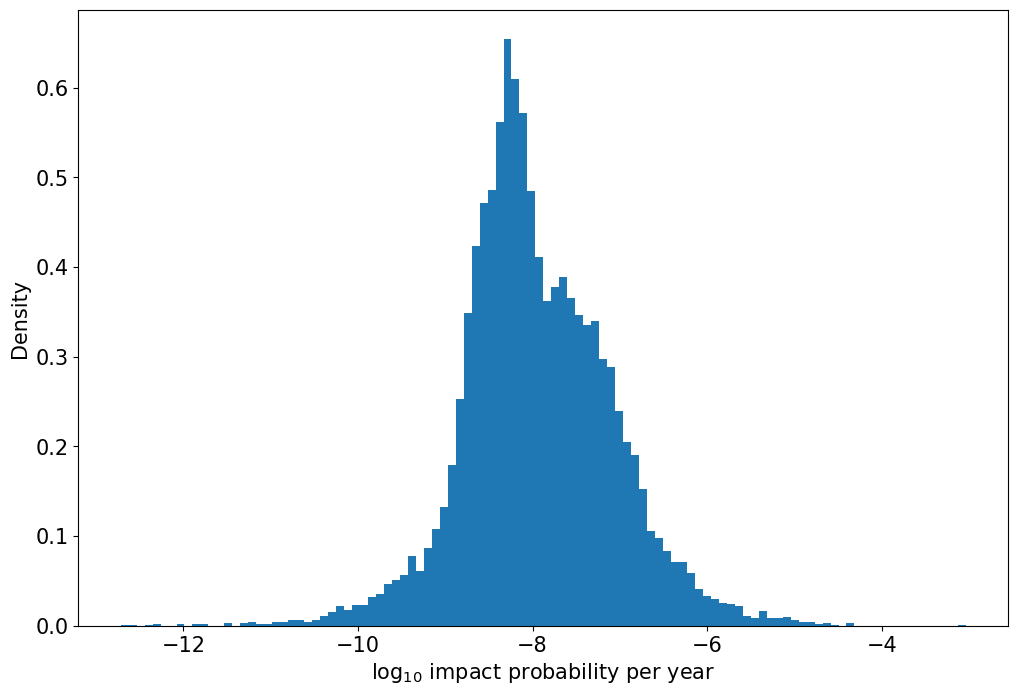

In [14]:
plt.rc('font', size=15)
# convert to lgo to make more readable
plt.figure(figsize = (12, 8))
# plot histogram
plt.hist(np.log10(impactor_pts_flat), bins='auto', density=True)
# label axes
plt.xlabel(r'$\log_{10}\,$impact probability per year'), plt.ylabel('Density')

Eliminate all clones with `nan` annual impact probabilities:

In [15]:
non_nan_mask = ~np.isnan(impactor_pts_flat)  # mask of all non-nan impact probabilities
# filter out nan impact probabilities
impactor_pts_flat_filtered = impactor_pts_flat[non_nan_mask]
impactor_qs_flat_filtered = impactor_qs_flat[non_nan_mask]

# filter out points with too high impact probability (say above 1e-4)
high_impact_prob_mask = impactor_pts_flat_filtered < 1e-4
impactor_pts_flat_filtered = impactor_pts_flat_filtered[high_impact_prob_mask]
impactor_qs_flat_filtered = impactor_qs_flat_filtered[high_impact_prob_mask]

(Text(0.5, 0, 'Annual impact probability'), Text(0, 0.5, 'q'))

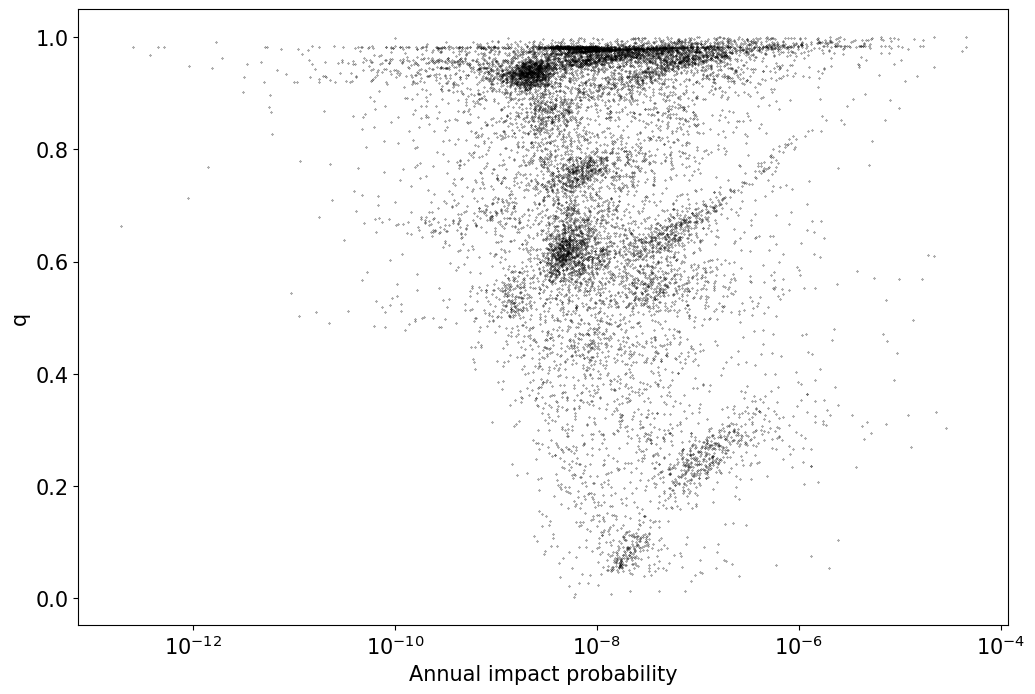

In [16]:
plt.figure(figsize = (12, 8))
plt.scatter(impactor_pts_flat_filtered, impactor_qs_flat_filtered, s=0.07, c='k')
plt.xscale('log')
plt.xlabel('Annual impact probability'), plt.ylabel('q')

Then plot a histogram comparing the weighted and unweighted $q$ values for the cloned impactors as well as a histogram of the $q$ values for the cloned impactors, weighting by impact probability:

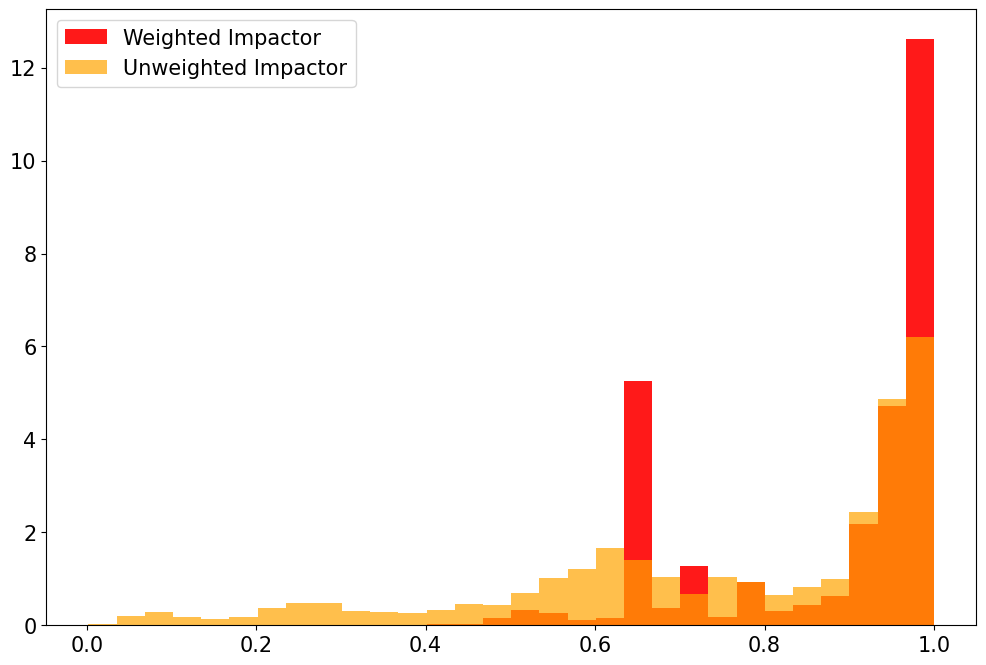

In [17]:
plt.figure(figsize = (12, 8))
plt.hist(impactor_qs_flat_filtered, bins=30, color = 'red', label = 'Weighted Impactor', density=True, 
         weights=1./impactor_pts_flat_filtered, alpha=0.9)
plt.hist(impactor_qs_flat_filtered, bins=30, color = 'orange', label = 'Unweighted Impactor', density=True, 
         weights=None, alpha=0.7)
# plt.yscale('log')
plt.legend()

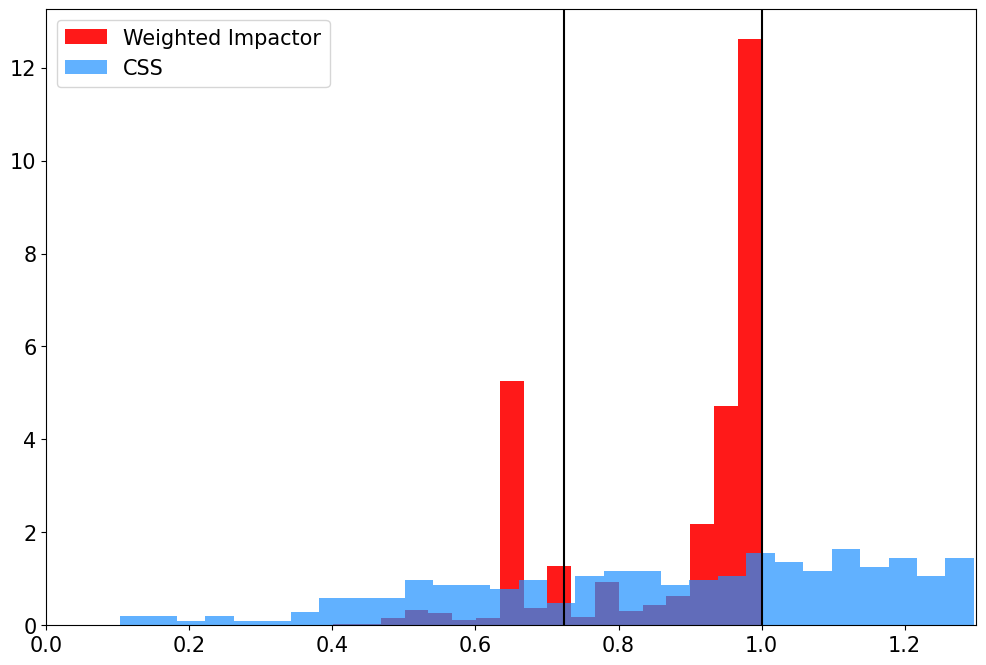

In [18]:
# semi major axes of earth and venus
a_earth = 1.
a_venus = 0.72333199

plt.figure(figsize = (12, 8))
plt.hist(impactor_qs_flat_filtered, bins=30, color = 'red', label = 'Weighted Impactor', density=True, 
         weights=1./impactor_pts_flat_filtered, alpha=0.9)
plt.hist(mag_limited_qs, bins=30, color='dodgerblue', label = 'CSS', density=True, 
         weights=None, alpha=0.7)
# plt.yscale('log')
plt.axvline(a_earth, color = 'k')
plt.axvline(a_venus, color = 'k')
plt.xlim(left=0., right=1.3)
plt.legend()

Weighted K-S test:

In [19]:
from scipy.stats import distributions

def ks_weighted(data1, data2, wei1, wei2, alternative='two-sided'):
    ix1 = np.argsort(data1)
    ix2 = np.argsort(data2)
    data1 = data1[ix1]
    data2 = data2[ix2]
    wei1 = wei1[ix1]
    wei2 = wei2[ix2]
    data = np.concatenate([data1, data2])
    cwei1 = np.hstack([0, np.cumsum(wei1)/sum(wei1)])
    cwei2 = np.hstack([0, np.cumsum(wei2)/sum(wei2)])
    cdf1we = cwei1[np.searchsorted(data1, data, side='right')]
    cdf2we = cwei2[np.searchsorted(data2, data, side='right')]
    d = np.max(np.abs(cdf1we - cdf2we))
    # calculate p-value
    n1 = data1.shape[0]
    n2 = data2.shape[0]
    m, n = sorted([float(n1), float(n2)], reverse=True)
    en = m * n / (m + n)
    if alternative == 'two-sided':
        prob = distributions.kstwo.sf(d, np.round(en))
    else:
        z = np.sqrt(en) * d
        # Use Hodges' suggested approximation Eqn 5.3
        # Requires m to be the larger of (n1, n2)
        expt = -2 * z**2 - 2 * z * (m + 2*n)/np.sqrt(m*n*(m+n))/3.0
        prob = np.exp(expt)
    return d, prob

Computing 1-D K-S test for unweighted and weighted $q$ values and compare unweighted result to default `scipy` K-S test implementation:

In [20]:
print('Unweighted:', ks_weighted(impactor_qs_flat_filtered, np.array(mag_limited_qs), 
                  np.ones(len(impactor_qs_flat_filtered)), np.ones(len(np.array(mag_limited_qs))))) 
print('Weighted:', ks_weighted(impactor_qs_flat_filtered, np.array(mag_limited_qs), 
                  1./impactor_pts_flat_filtered, np.ones(len(np.array(mag_limited_qs)))))

Unweighted: (0.4081625694808695, 9.108968236576666e-39)
Weighted: (0.4200892758333925, 3.846300432304518e-41)


In [21]:
scipy.stats.ks_2samp(impactor_qs_flat_filtered, mag_limited_qs).statistic, scipy.stats.ks_2samp(impactor_qs_flat_filtered, mag_limited_qs).pvalue

(0.4081625694808695, 9.108968236576666e-39)